In [982]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import math
import copy
import pandas as pd

from enum import Enum
from scipy.stats import truncnorm

import seaborn as sns
sns.set_color_codes('bright')


# Auction Simulation


## Enums and Static Values


In [983]:
class BIDDER_TYPE(Enum):
    influencer = 1
    reactor = 2


In [984]:
new_line = '\n'
new_line_space = '\n' + '   '


## Helper Functions


In [985]:
def get_truncated_normal(mean, std, count, low=0, upp=1):
    a, b = (low - mean) / std, (upp - mean) / std

    return truncnorm.rvs(
        a, b, loc=mean, scale=std, size=count)


In [986]:
def get_bidder_type(beta_0):
    if beta_0 < 0.5:
        return BIDDER_TYPE.reactor
    
    return BIDDER_TYPE.influencer

In [987]:
def average_value(values):
    return sum(values) / len(values)


In [988]:
def calculate_alpha(private_info, consensus_bias):
    # beta = 1/std^2
    return 1/math.pow(average_value([1-private_info, 1-consensus_bias]), 2)


In [989]:
def calculate_beta_d(no_bidders, desire, risk):
    # beta = 1/std^2
    return 1/math.pow(average_value([1-no_bidders, 1-desire, 1-risk]), 2)


In [990]:
def get_value_belief_dist(private_value, beta, no_bidders):
    # loc: mean
    # scale: std (sigma)
    # size: how many numbers to generate
    return np.random.normal(loc=private_value, scale=math.sqrt(1/beta), size=no_bidders)


In [991]:
def update_belief_set(bidder, new_bid_amount, no_bidders, time, total_time):
    perc_time_passed = float(time)/float(total_time)


    beta_t = bidder.beta
    beta_d = bidder.beta_d * math.pow(perc_time_passed, 2)

    beta_new = beta_t + beta_d
    new_mean = ((beta_t/beta_new) * bidder.curr_value) + ((beta_d/beta_new) * new_bid_amount)



    bidder.curr_value = math.floor(new_mean)
    bidder.beta = beta_new
    bidder.value_belief_distribution = get_value_belief_dist(
        bidder.curr_value, bidder.beta, no_bidders)


### Plotting


In [992]:
def plot_belief_distributions(belief_sets, title):
    plt.figure(figsize=(20, 12))

    belief_set_df = pd.concat([pd.Series(x) for x in belief_sets], axis=1)

    sns.displot(data=belief_set_df, kind="kde").set(
        title=title, xlabel='Item Value', ylabel='Density')

    plt.show()


## Classes


In [993]:
class Auction:
    def __init__(self, id, N, T, reserve, start_bid):
        self.id = id

        # static values
        self.N = N
        self.T = T
        self.reserve = reserve
        self.start_bid = start_bid
        self.bidders = None

        # dynamic values
        self.t = 0
        self.curr_bid = start_bid

    def __str__(self) -> str:

        attribute_strings = (
            'id: ' + self.id + new_line_space +
            'no. bidders: ' + str(self.N) + new_line_space +
            'duration: ' + str(self.T) + new_line_space +
            'reserve: ' + str(self.reserve) + new_line
        )

        return (
            'Auction(' + new_line_space +
            attribute_strings +
            ')' + new_line
        )


In [994]:

class Bidder:
    def __init__(self, name, bidder_type, predef_value, beta_0, beta_d, desire_coef, value_belief_distribution):
        self.name = name

        # static values
        self.bidder_type = bidder_type  # influencer bidder or reactor
        self.predef_value = predef_value  # bidder's estimated value of item pre-auction

        # derived coefficients
        self.beta_0 = beta_0  # how much bidder trusts his original value estimate
        self.beta = beta_0 # how much bidder trusts his current value estimate
        self.beta_d = beta_d  # how much the bidder is willing to adapt to incoming information

        # dynamic values
        # how much does the bidder want the item? Increases with no. bids submitted
        self.desire_coef = desire_coef
        self.curr_value = predef_value  # bidders updated in-auction value
        self.is_active = True  # all bidders start active
        self.no_bids_submitted = 0
        # what he thinks other bidder's values are
        self.value_belief_distribution = value_belief_distribution

    def __str__(self) -> str:

        attribute_strings = (
            'name: ' + self.name + new_line_space +
            'predef_value: ' + str(self.predef_value) + new_line_space +
            'curr_value: ' + str(self.curr_value) + new_line_space +
            'beta_0: ' + str(self.beta_0) + new_line_space +
            'beta: ' + str(self.beta) + new_line_space +
            'beta_d: ' + str(self.beta_d) + new_line_space +
            'bidder_type: ' + str(self.bidder_type) + new_line
        )

        return (
            'Bidder(' + new_line_space +
            attribute_strings +
            ')' + new_line
        )


In [995]:
class Bid:
    def __init__(self, amount: int, bidder: Bidder):
        self.amount = amount
        self.bidder = bidder

    def __str__(self) -> str:
        return 'Bid(amount=' + str(self.amount) + ' ,bidder=' + str(self.bidder) + ')'


## Simulation Functions


In [996]:
def get_bidder_bid(curr_bid: Bid, curr_time: int, bidder: Bidder, duration: int):
    bid_amount = 0

    is_time_to_bid = (
        (bidder.bidder_type == BIDDER_TYPE.influencer)
        |
        (
            # bids if time 90% of T or bid 90% of value
            (bidder.bidder_type == BIDDER_TYPE.reactor)
            &
            ((curr_time > 0.9 * duration) |
             (curr_bid.amount > bidder.curr_value * 0.9))
        )
    )

    # influencer vs. reactor
    if (is_time_to_bid & (curr_bid.bidder != bidder) & (curr_bid.amount < bidder.curr_value)):
        # bid random btw. current bid and halfway from current bid to own value
        bid_amount = rd.randint(curr_bid.amount, math.floor(
            curr_bid.amount + (bidder.curr_value - curr_bid.amount) / 2))

    return bid_amount


In [997]:

def run_auction(auction):
    auction.curr_bid = auction.start_bid
    auction.t = 0
    no_more_bids = False

    while ((auction.t < auction.T) & (not no_more_bids)):
        bids = []

        for bidder in auction.bidders:
            bid_amount = get_bidder_bid(
                auction.curr_bid, auction.t, bidder, auction.T)

            if (bid_amount > auction.curr_bid.amount):
                bids.append(Bid(bid_amount, bidder))

        if (len(bids) > 0):
            max_bid = max(bids, key=lambda bid: bid.amount)
            auction.curr_bid = max_bid
            auction.curr_bid.bidder.no_bids_submitted += 1
            for bidder in auction.bidders:
                update_belief_set(
                    bidder=bidder, new_bid_amount=auction.curr_bid.amount, no_bidders=auction.N, time=auction.t, total_time=auction.T)

        else:
            no_more_bids = True

        auction.t += 1

    return auction.curr_bid


In [998]:
def run_simulation(no_iterations):
    # mean and standard deviation of private values
    # std: how affiliated are the private values?? TODO!!
    avg, std = 6000, 100
    winning_bids = []
    all_bidders = []
    for i in range(0, no_iterations):
        auction = Auction(id='a'+str(i+1), N=15, T=50,
                          reserve=95, start_bid=Bid(0, None))

        bidder_private_values = [math.floor(x) for x in get_truncated_normal(
            mean=avg, std=std, count=auction.N, low=0, upp=1000000)]
        bidder_private_infos = get_truncated_normal(
            mean=0.5, std=0.25, count=auction.N)
        bidder_consensus_bias = get_truncated_normal(
            mean=0.5, std=0.25, count=auction.N)
        bidder_desires = get_truncated_normal(
            mean=0.5, std=0.25, count=auction.N)
        bidder_risks = get_truncated_normal(
            mean=0.5, std=0.25, count=auction.N)

        bidders = []
        for i in range(0, auction.N):
            beta_0 = calculate_alpha(
                bidder_private_infos[i], bidder_consensus_bias[i])
            beta_d = calculate_beta_d(
                auction.N, bidder_desires[i], bidder_risks[i])
            bidder_type = get_bidder_type(beta_0)

            bidders.append(Bidder(
                name='b'+str(i+1),
                bidder_type=bidder_type,
                predef_value=bidder_private_values[i],
                beta_0=beta_0,
                beta_d=beta_d,
                desire_coef=bidder_desires[i],
                value_belief_distribution=get_value_belief_dist(bidder_private_values[i], beta_0, auction.N)))

        original_bidder_list = copy.deepcopy(bidders)

        auction.bidders = bidders

        winning_bids.append(run_auction(auction))
        all_bidders.append(auction.bidders)

    return winning_bids, all_bidders, original_bidder_list


## Simulation


In [999]:
winning_bids, all_bidders, original_bidder_list = run_simulation(3)


<Figure size 2000x1200 with 0 Axes>

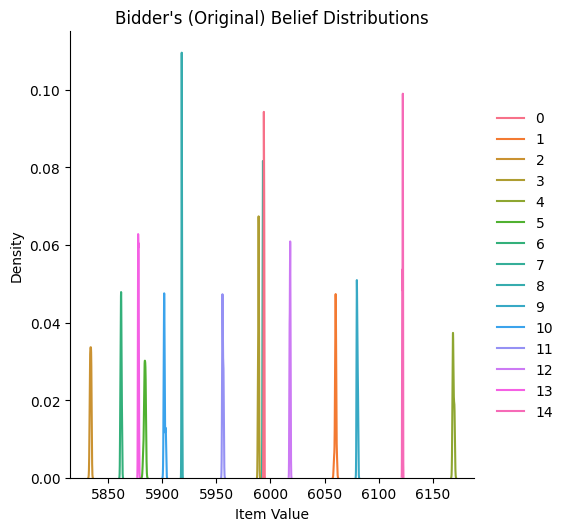

<Figure size 2000x1200 with 0 Axes>

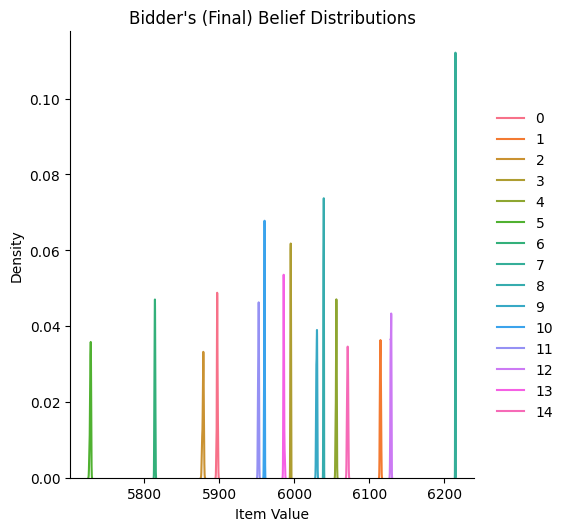

<Figure size 2000x1200 with 0 Axes>

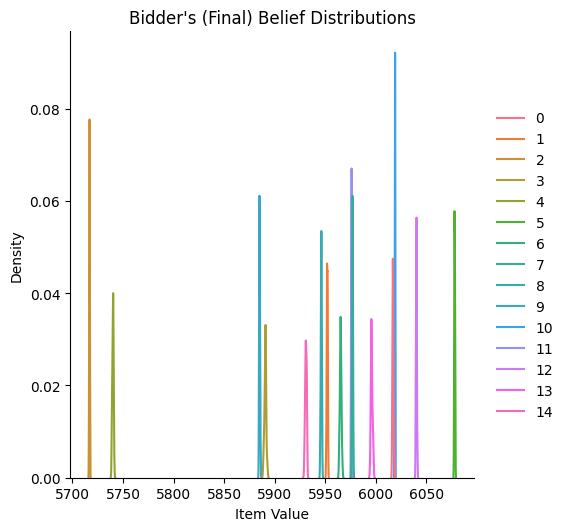

<Figure size 2000x1200 with 0 Axes>

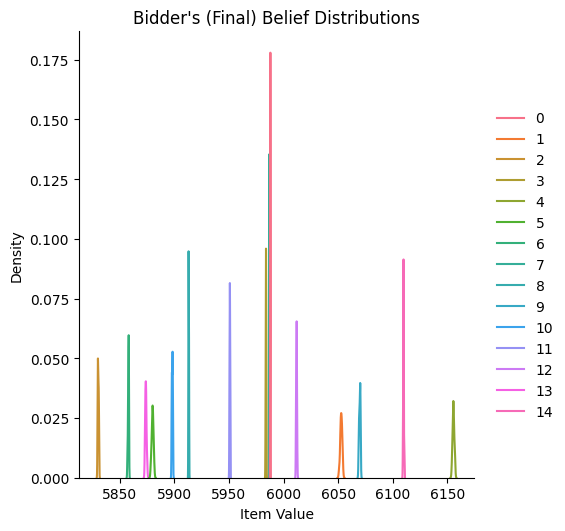

In [1000]:
plot_belief_distributions(list(map(lambda bidder: bidder.value_belief_distribution,
                                 original_bidder_list)), 'Bidder\'s (Original) Belief Distributions')

for bidder_list in all_bidders:
    plot_belief_distributions(list(map(lambda bidder: bidder.value_belief_distribution,
                                       bidder_list)), 'Bidder\'s (Final) Belief Distributions')


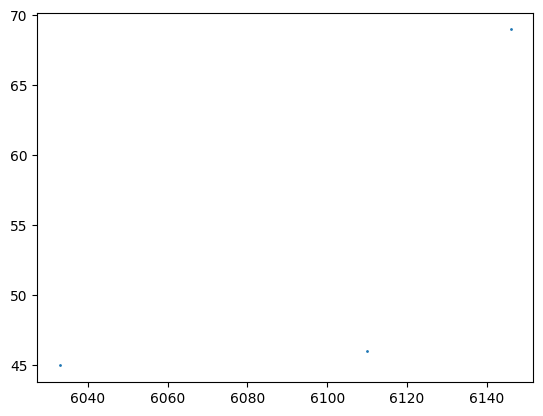

In [1001]:
# ---WINNING BID AMOUNT---
winning_bid_amounts = list(map(lambda bid: bid.amount, winning_bids))

# ---WINNING BIDDER UTILITY---
winning_bidder_utility = list(
    map(lambda bid: bid.bidder.curr_value - bid.amount, winning_bids))

#pd.value_counts(winning_bidder_utility).sort_index().plot.bar()

plt.scatter(x=winning_bid_amounts, y=winning_bidder_utility, s=1)
plt.show()


<AxesSubplot: >

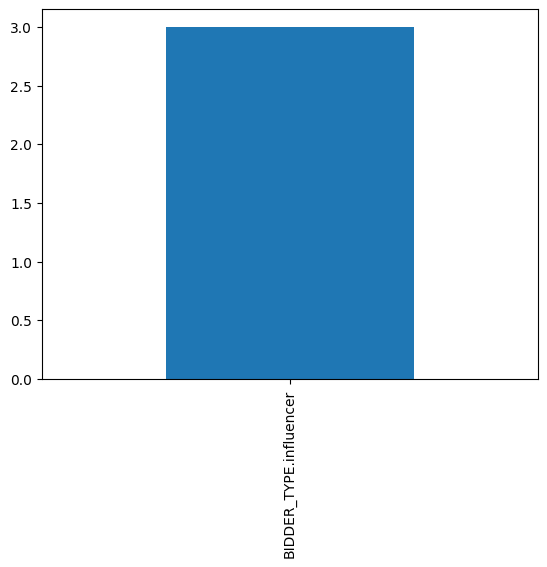

In [1002]:
# ---WINNING BIDDER TYPE---

winning_bidder_types = list(
    map(lambda bid: bid.bidder.bidder_type, winning_bids))

pd.value_counts(winning_bidder_types).plot.bar()


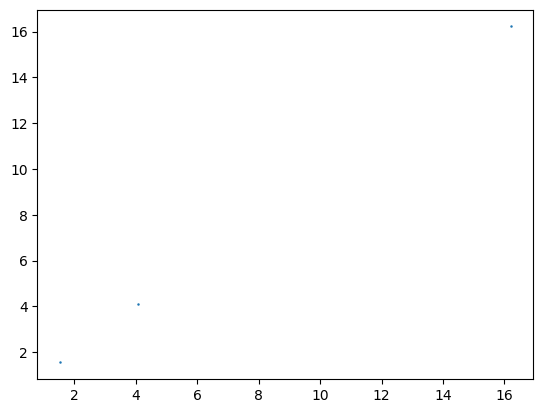

In [1003]:
# ---WINNING BIDDER UTILITY---
winning_bidder_beta_0 = list(
    map(lambda bid: bid.bidder.beta_0, winning_bids))

winning_bidder_beta = list(
    map(lambda bid: bid.bidder.beta, winning_bids))


plt.scatter(x=winning_bidder_beta_0, y=winning_bidder_beta, s=0.6)
plt.show()

<AxesSubplot: >

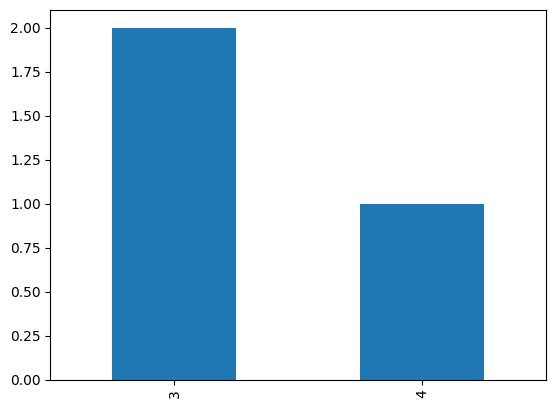

In [1004]:
# ---WINNING BIDDER NO BIDS SUBMITTED---
winning_bidder_bid_count = list(
    map(lambda bid: bid.bidder.no_bids_submitted, winning_bids))

pd.value_counts(winning_bidder_bid_count).sort_index().plot.bar()


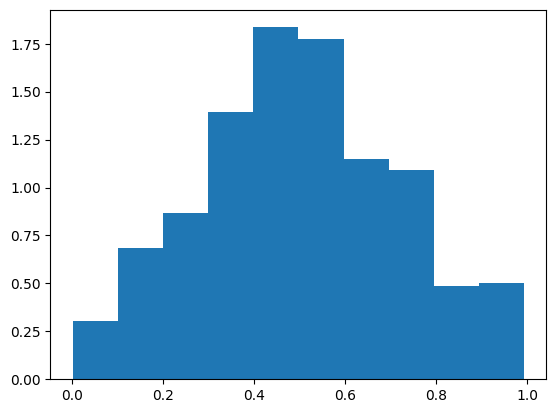

In [1005]:
foo = get_truncated_normal(
            mean=0.5, std=0.25, count=500)

plt.hist(foo, density=True)
plt.show()